<h1 style="text-align:center;">Лабораторна робота 5</h1>

<p><b>Тема:</b> OpenCV. Просторові методи обробки зображень. Робота з околом. Просторова фільтрація зображення (short version) </p>
<p><b>Мета:</b> знайомство з просторовими методами фільтрації зображень засобами OpenCV у середовищі Anaconda із застосуванням Jupyter Notebook засобами мови програмування Python.</p>
<h2 style="text-align:center;">Завдання для самостійної роботи</h2>

<p>1. <a href="https://docs.opencv.org/4.x/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html">Фільтр з ядром Гауса</a></p>
<p>Фільтрація Гауса використовує двовимірний гаусівський розподіл для розрахунку коефіцієнтів ядра згортки. Значення кожного пікселя обчислюється за формулою:</p>
$$
G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

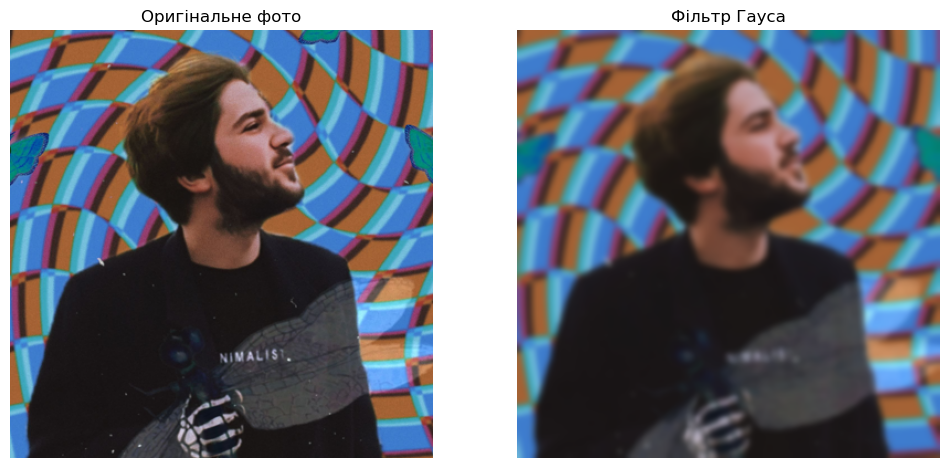

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

filename = 'src/photo.png' 
image = cv2.imread(filename)

if image is None:
    print(f"Помилка: Не вдалося знайти файл {filename}")
else:
    gaussian_blur = cv2.GaussianBlur(image, (15, 15), 0)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title("Оригінальне фото")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if len(gaussian_blur.shape) == 3:
        plt.imshow(cv2.cvtColor(gaussian_blur, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(gaussian_blur, cmap='gray')
    plt.title("Фільтр Гауса")
    plt.axis('off')

    plt.show()

<p>1) Написати процедуру, яка б зашумлювала нормальним шумом з параметрами $(n, \mu, \sigma)$ зображення</p>

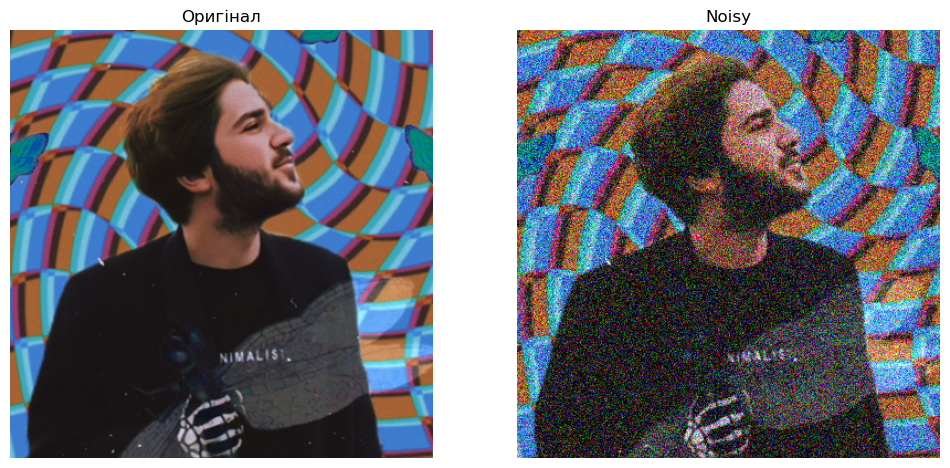

In [27]:
import numpy as np
import cv2 as cv

def add_gaussian_noise(image: np.ndarray, mu: float = 0.0, sigma: float = 10.0) -> np.ndarray:
    img_f = image.astype(np.float32)
    noise = np.random.normal(mu, sigma, img_f.shape).astype(np.float32)
    noisy = img_f + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

if __name__ == "__main__":
    portrait_path = 'src/photo.png'
    img = cv.imread(portrait_path, cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(portrait_path)
    noisy = add_gaussian_noise(img, mu=0.0, sigma=50.0)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title('Оригінал'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(cv.cvtColor(noisy, cv.COLOR_BGR2RGB)); plt.title('Noisy'); plt.axis('off')
    plt.show()

<p>2) Взявши за основу власний портрет, зашумити його нормальним шумом</p>

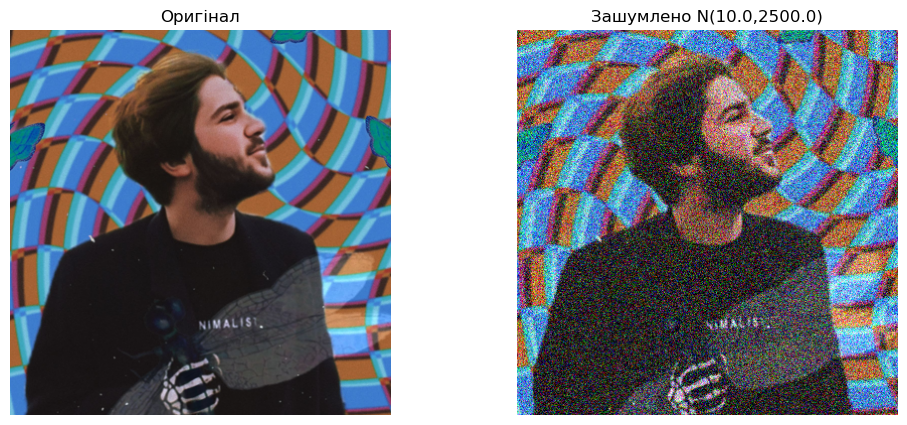

In [18]:
import cv2 as cv
import matplotlib.pyplot as plt

portrait_path = 'src/photo.png'
img = cv.imread(portrait_path)
if img is None:
    raise FileNotFoundError(portrait_path)
mu = 10.0
sigma = 50.0
noisy_img = add_gaussian_noise(img, mu=mu, sigma=sigma)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title('Оригінал'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(noisy_img, cv.COLOR_BGR2RGB)); plt.title('Зашумлено'); plt.axis('off')
plt.show()

<p>3) Реалізувати медіанний фільтр і продемонструвати послідовно роботу медіанного і гаусового фільтру, оптимально підібравши і обґрунтувавши значення параметрів</p>

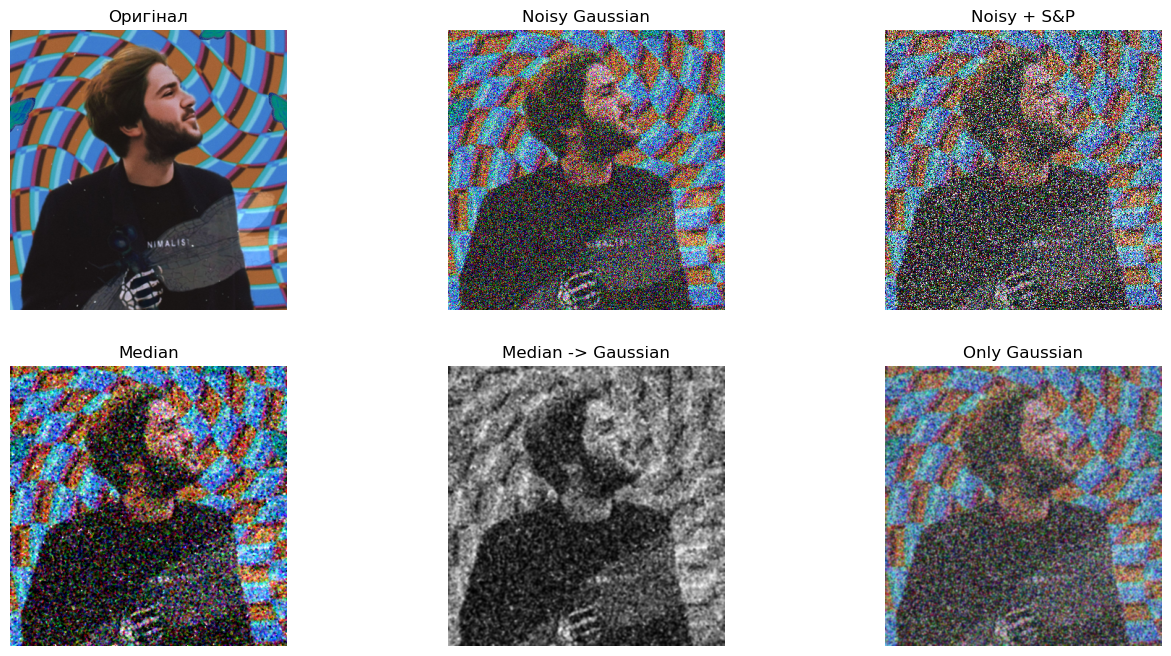

In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(image: np.ndarray, sigma: float) -> np.ndarray:
    row, col, ch = image.shape
    mean = 0
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy_img = image + gauss
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return noisy_img

def gaussian_kernel(ksize: int, sigma: float) -> np.ndarray:
    center = ksize // 2
    x, y = np.mgrid[-center:center+1, -center:center+1]
    g = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    kernel = g / g.sum()
    return kernel

def apply_convolution(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    assert image.ndim == 2
    img_float = image.astype(np.float32)
    output = cv.filter2D(img_float, -1, kernel)
    return np.clip(output, 0, 255).astype(np.uint8)

def median_filter(image: np.ndarray, ksize:int) -> np.ndarray:
    assert ksize % 2 == 1
    if image.ndim == 2:
        return cv.medianBlur(image, ksize)
    else:
        chans = cv.split(image)
        filtered = [cv.medianBlur(c, ksize) for c in chans]
        return cv.merge(filtered)

if __name__ == "__main__":
    portrait_path = 'src/photo.png'
    img = cv.imread(portrait_path)
    
    if img is None:
        raise FileNotFoundError(portrait_path)
    
    # ЗБІЛЬШЕНО: sigma = 100.0
    noisy = add_gaussian_noise(img, sigma=100.0)
    
    sp = noisy.copy()
    # ЗБІЛЬШЕНО: prob = 0.02
    prob = 0.2
    rnd = np.random.rand(*sp.shape[:2])
    sp[rnd < prob/2] = 0
    sp[rnd > 1 - prob/2] = 255
    
    med_ksize = 3
    gauss_ksize = 5
    gauss_sigma = 1.0

    med = median_filter(sp, med_ksize)
    
    gaussian_kernel_manual = gaussian_kernel(gauss_ksize, gauss_sigma)
    
    image_to_convolve = med
    if image_to_convolve.ndim == 3:
        image_to_convolve = cv.cvtColor(med, cv.COLOR_BGR2GRAY)
        
    after_gauss = apply_convolution(image_to_convolve, gaussian_kernel_manual)
    
    only_gauss = cv.GaussianBlur(sp, (gauss_ksize, gauss_ksize), gauss_sigma)

    plt.figure(figsize=(16,8))
    
    plt.subplot(2,3,1); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title('Оригінал'); plt.axis('off')
    plt.subplot(2,3,2); plt.imshow(cv.cvtColor(noisy, cv.COLOR_BGR2RGB)); plt.title('Noisy Gaussian'); plt.axis('off')
    plt.subplot(2,3,3); plt.imshow(cv.cvtColor(sp, cv.COLOR_BGR2RGB)); plt.title('Noisy + S&P'); plt.axis('off')
    
    plt.subplot(2,3,4); plt.imshow(cv.cvtColor(med, cv.COLOR_BGR2RGB)); plt.title('Median'); plt.axis('off')
    plt.subplot(2,3,5); plt.imshow(after_gauss, cmap='gray'); plt.title('Median -> Gaussian'); plt.axis('off')
    plt.subplot(2,3,6); 
    plt.imshow(cv.cvtColor(only_gauss, cv.COLOR_BGR2RGB)); plt.title(f'Only Gaussian'); plt.axis('off')
    
    plt.show()

<p>Якщо на зображенні присутній імпульсний шум, варто почати з медіанного фільтра з вікном k=3 або k=5. Значення k=3 майже не зачіпає дрібні деталі, тоді як k=5 ефективніше прибирає шум, але може розмивати дрібні елементи.</p> <p>Після медіанного фільтрування можна застосувати гаусівський фільтр, щоб усунути залишки звичайного шуму. Типовий стартовий варіант — ядро 5×5 та sigma приблизно 1.0.</p>

<p>2. <a href="https://docs.opencv.org/4.x/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html">Двосторонній фільтр</a></p>

Формула: 
$$
g(x, y) = \frac{1}{W_p} \sum_{x_i, y_i \in \Omega} f(x_i, y_i) \cdot G_{\sigma_s}(\| (x,y) - (x_i,y_i) \|) \cdot G_{\sigma_r}(| f(x,y) - f(x_i,y_i) |)
$$

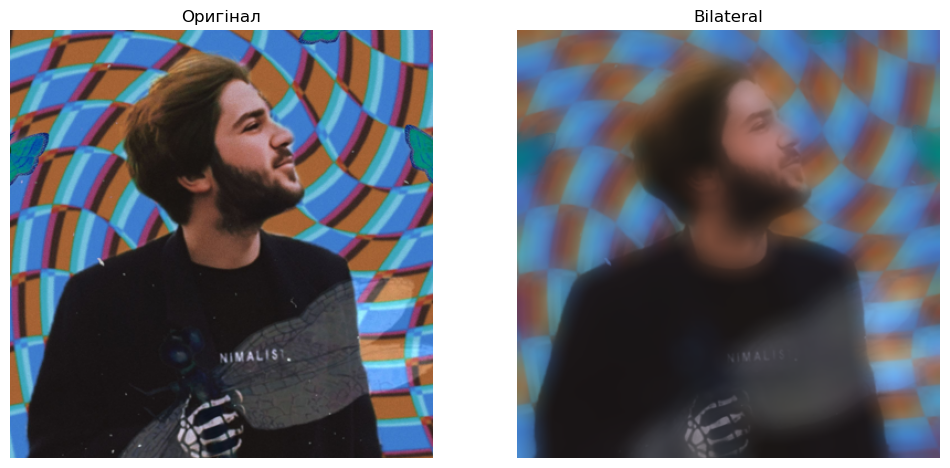

In [28]:
import cv2 as cv
import matplotlib.pyplot as plt

def bilateral_filter(image: np.ndarray, d:int, sigmaColor:float, sigmaSpace:float) -> np.ndarray:

    return cv.bilateralFilter(image, d, sigmaColor, sigmaSpace)

if __name__ == "__main__":
    portrait_path = 'src/photo.png'
    img = cv.imread(portrait_path)
    if img is None:
        raise FileNotFoundError(portrait_path)

    d = 35 
    sigmaColor = 250
    sigmaSpace = 250

    bf = bilateral_filter(img, d, sigmaColor, sigmaSpace)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); 
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));
    plt.title('Оригінал'); 
    plt.axis('off')
    plt.subplot(1,2,2); 
    plt.imshow(cv.cvtColor(bf, cv.COLOR_BGR2RGB)); 
    plt.title(f'Bilateral'); 
    plt.axis('off')
    plt.show()

1)Написати процедуру, до складу якої б входили всі низькочастотні фільтри, які досліджуються в цій лабораторній роботі, а вибір потрібного задавався відповідним вхідним параметром.

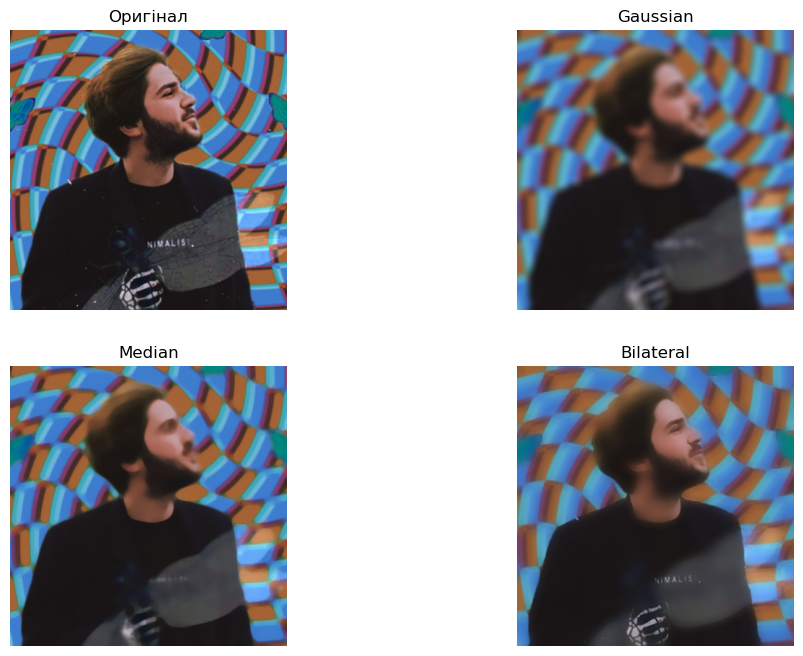

In [26]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def median_filter(image, ksize):
    return cv.medianBlur(image, ksize)

def bilateral_filter(image, d, sigmaColor, sigmaSpace):
    return cv.bilateralFilter(image, d, sigmaColor, sigmaSpace)

def gaussian_kernel(size, sigma):
    kernel = cv.getGaussianKernel(size, sigma)
    return np.outer(kernel, kernel)

def apply_convolution(image, kernel):
    return cv.filter2D(image, -1, kernel)

def lowpass_filter_dispatch(image: np.ndarray, method: str, **kwargs) -> np.ndarray:
    method = method.lower()
    if method == 'gaussian_manual':
        ksize = kwargs.get('ksize', 5)
        sigma = kwargs.get('sigma', 1.0)
        kernel = gaussian_kernel(ksize, sigma)
        return apply_convolution(image, kernel)
    elif method == 'gaussian_cv':
        ksize = kwargs.get('ksize', 5)
        sigma = kwargs.get('sigma', 1.0)
        return cv.GaussianBlur(image, (ksize, ksize), sigmaX=sigma, borderType=cv.BORDER_REPLICATE)
    elif method == 'median':
        ksize = kwargs.get('ksize', 3)
        return median_filter(image, ksize)
    elif method == 'bilateral':
        d = kwargs.get('d', 9)
        sigmaColor = kwargs.get('sigmaColor', 75)
        sigmaSpace = kwargs.get('sigmaSpace', 75)
        return bilateral_filter(image, d, sigmaColor, sigmaSpace)
    elif method == 'average':
        ksize = kwargs.get('ksize', 3)
        return cv.blur(image, (ksize, ksize))
    else:
        raise ValueError(f"Невідомий метод: {method}")

if __name__ == "__main__":
    portrait_path = 'src/photo.png'
    img = cv.imread(portrait_path)
    if img is None:
       raise FileNotFoundError(portrait_path)
        
    out1 = lowpass_filter_dispatch(img, 'gaussian_cv', ksize=15, sigma=5.0)
    out2 = lowpass_filter_dispatch(img, 'median', ksize=11)
    out3 = lowpass_filter_dispatch(img, 'bilateral', d=25, sigmaColor=150, sigmaSpace=150)
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title('Оригінал'); plt.axis('off')
    plt.subplot(2,2,2); plt.imshow(cv.cvtColor(out1, cv.COLOR_BGR2RGB)); plt.title('Gaussian'); plt.axis('off')
    plt.subplot(2,2,3); plt.imshow(cv.cvtColor(out2, cv.COLOR_BGR2RGB)); plt.title('Median'); plt.axis('off')
    plt.subplot(2,2,4); plt.imshow(cv.cvtColor(out3, cv.COLOR_BGR2RGB)); plt.title('Bilateral'); plt.axis('off')
    plt.show()

<h2 style="font-weight:bold; font-size:22px;">Контрольні запитання</h2>

<h>1. У чому полягає сенс градаційних перетворень?</h>

<p>Градаційні перетворення — це способи зміни яскравості та контрасту зображення, які виконуються шляхом перерахунку значень пікселів за заданою залежністю.</p>
<p>Їх застосовують для:</p>
<ol>
  <li>Покращення візуальної якості зображення (підвищення контрасту, освітлення або затемнення, розширення діапазону яскравостей).</li>
  <li>Підготовки зображення до подальшої обробки (виділення контурів, підкреслення деталей, сегментація).</li>
  <li>Виправлення недоліків умов зйомки (надмірна або недостатня освітленість, слабкий контраст).</li>
  <li>Приведення рівнів інтенсивності до єдиного вигляду для задач комп’ютерного зору.</li>
</ol>
<p>Типові приклади градаційних перетворень:</p>
<li>отримання негативу;</li>
<li>гамма-корекція;</li>
<li>лінійне розтягування контрасту;</li>
<li>логарифмічні та експоненціальні перетворення;</li>
<br>

<h>2. На чому ґрунтуються гістограмні методи?</h>

<p>Гістограмні методи ґрунтуються на аналізі та модифікації гістограми інтенсивностей — графіка, що показує, як часто зустрічаються певні рівні яскравості або кольору.</p>
<p>Основна ідея полягає у зміні розподілу яскравостей з метою:</p>
<li>розширення або вирівнювання гістограми,</li>
<li>керування контрастом,</li>
<li>усунення впливу нерівномірного освітлення.</li>
<br>
<p>Ключові принципи роботи:</p>
<li>Вузька гістограма свідчить про низький контраст, тому її доцільно розширювати.</li>
<li>Нерівномірний розподіл яскравостей можна зробити більш рівномірним.</li>
<li>Для наближення вигляду зображення до еталонного застосовують специфікацію гістограми.</li>
<br>
<p>Приклади гістограмних методів:</p>
<li>Гістограмне вирівнювання (histogram equalization) — забезпечує більш рівномірний контраст.</li>
<li>CLAHE — локальне підсилення контрасту з контролем рівня підсилення.</li>
<li>Специфікація (matching) — підлаштування зображення під задану гістограму.</li>
